# Simple 1010 Pattern

Make Your First GAN With PyTorch, 2020

In [1]:
from rich import print

## import libraries

In [2]:
import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt
import random
import numpy

## Data Functions

In [3]:
# function to generate real data

def generate_real():
    real_data = torch.FloatTensor(
        [random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2),
         random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2)])
    return real_data

In [4]:
# function to generate uniform random data

def generate_random(size):
    random_data = torch.rand(size)
    return random_data

## Discriminator Network

In [5]:
class Discriminator(nn.Module):
    """Discriminator class
    """
    def __init__(self):
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            
        # print counter every 10000
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(min(self.progress), max(self.progress)), figsize=(16,8), alpha=0.1, marker='.', grid=True)

## Test Discriminator

In [6]:
# test discriminator can separate real data from random noise

# create discriminator
D = Discriminator()

# train discriminator
for i in range(10000):
    # real data
    D.train(generate_real(), torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random(4), torch.FloatTensor([0.0]))

counter =  10000

counter =  20000

<Figure size 1152x576 with 1 Axes>

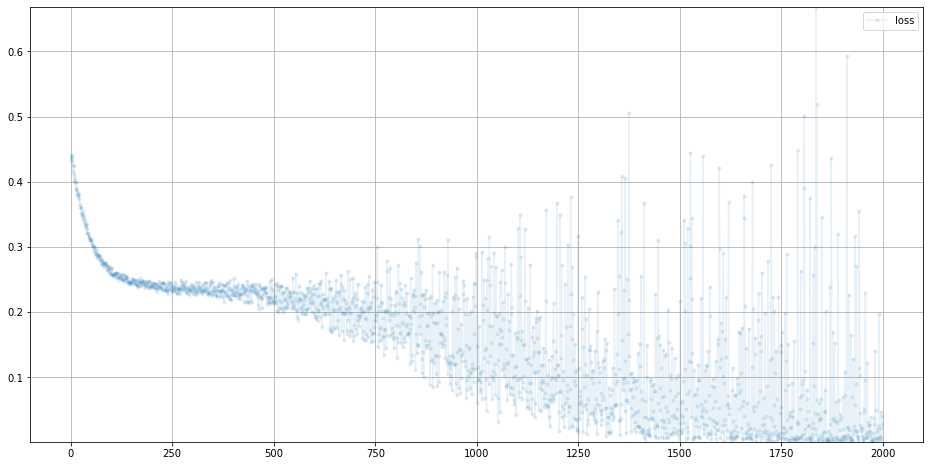

In [7]:
# plot discriminator loss

D.plot_progress()

In [8]:
# manually run discriminator to check it can tell real data from fake

print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

0.7873883843421936

0.129741370677948

## Generator Network

In [9]:
class Generator(nn.Module):
    """Generator class
    """
    def __init__(self):
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(1, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(min(self.progress), max(self.progress)), figsize=(16,8), alpha=0.1, marker='.', grid=True)

## Test Generator Output

In [10]:
# check the generator output is of the right type and shape

G = Generator()

G.forward(torch.FloatTensor([0.5]))

tensor([0.3943, 0.4186, 0.3914, 0.4601], grad_fn=<SigmoidBackward0>)

## Train GAN

In [11]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()

image_list = []

# train Discriminator and Generator

for i in range(10000):
    
    # train discriminator on true
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
    
    # train generator
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))
    
    # add image to list every 1000
    if (i % 1000 == 0):
        image_list.append(G.forward(torch.FloatTensor([0.5])).detach().numpy())

counter =  10000

counter =  20000

CPU times: user 17.4 s, sys: 1.25 s, total: 18.7 s
Wall time: 16.4 s


<Figure size 1152x576 with 1 Axes>

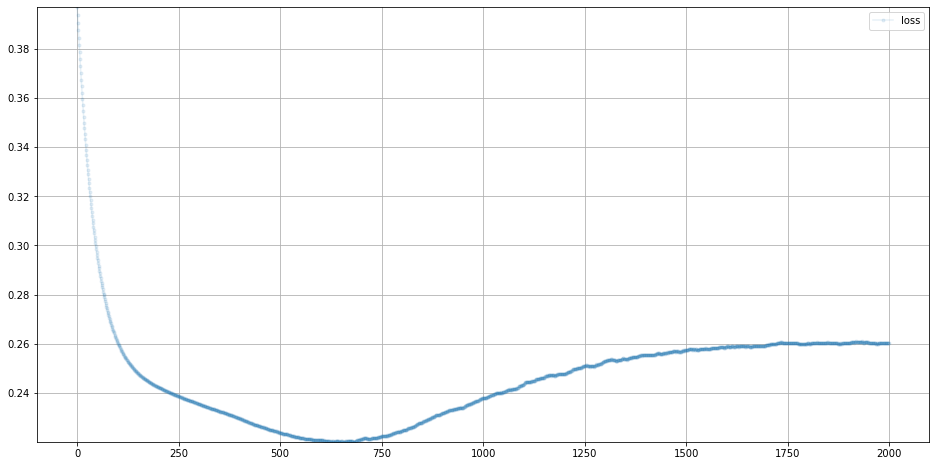

In [12]:
# plot discriminator error

D.plot_progress()

<Figure size 1152x576 with 1 Axes>

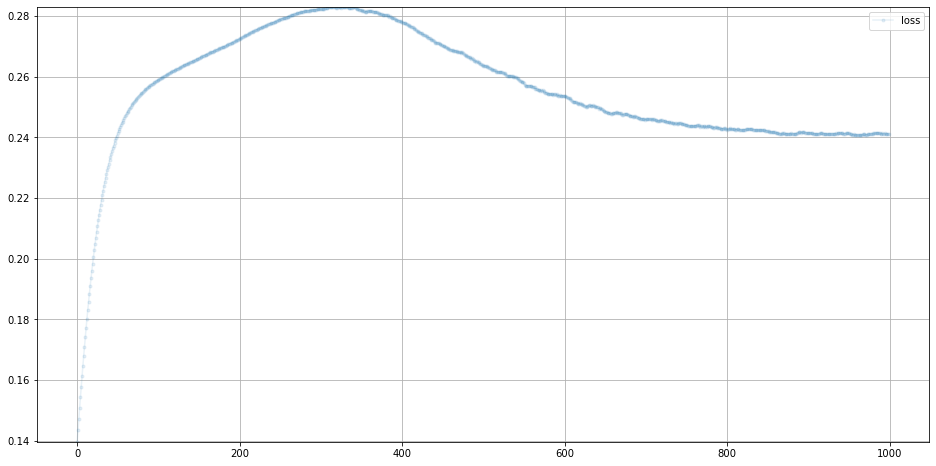

In [13]:
# plot generator error

G.plot_progress()

## Manually Run Generator

In [14]:
# manually run generator to see it's outputs

G.forward(torch.FloatTensor([0.5]))

tensor([0.8936, 0.0382, 0.9478, 0.0530], grad_fn=<SigmoidBackward0>)

## Visualise Pattern During Training

<matplotlib.image.AxesImage object at 0x7fe1e1bcfd90>

<Figure size 1152x576 with 1 Axes>

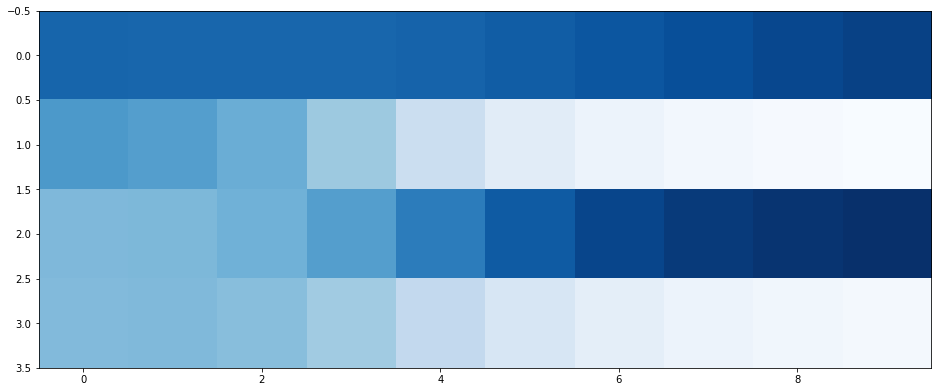

In [15]:
# plot images collected during training

plt.figure(figsize = (16,8))

plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')